# AMAZON FINE FOOD REVIEWS

OBJECTIVE:

*   TO FIND THE OPTIMAL VALUE OF 'K'(No. of nearest neighbours)
*   TO FIND THE ACCURACY SCORE OF OUR PREDICTION ON TEST DATASET.

NOTE:

*   Dataset is preprocessed and time-based splitted(Train , Test , Cross-Validate).
*  SAMPLE_SIZE: 100000 Reviews (70K-TRAIN , 15K-CROSS_VALIDATE , 15K-TEST).








IMPORTING LIBRARIES AND OUR DATASET

In [0]:
import numpy as np
import pandas as pd
import seaborn as sn
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from prettytable import PrettyTable

IMPORTING THE PREPROCESSED AND TIME_BASED SPLITTED DATASET

In [0]:
Train=joblib.load('TRAIN.joblib')
CrossVal=joblib.load('CROSS_VALIDATE.joblib')
Test=joblib.load('TEST.joblib')

In [0]:
Train_x=Train['Text'].values
CrossVal_x=CrossVal['Text'].values
Test_x=Test['Text'].values
Train_y=Train['Score'].values
CrossVal_y=CrossVal['Score'].values
Test_y=Test['Score'].values

**1. BAG OF WORDS**

**1.1 BRUTE-FORCE METHOD**

In [0]:
count= CountVectorizer()

In [0]:
count.fit(Train_x)
Train_BOW = count.transform(Train_x)
CrossVal_BOW = count.transform(CrossVal_x)
Test_BOW= count.transform(Test_x) 

**Hyperparameter( K ) tuning .**

In [0]:
Mylist=list(range(50))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in neighbour:
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  neigh.fit(Train_BOW, Train_y)
  Train_y_pred =  neigh.predict_proba(Train_BOW)[:,1]
  Train_AUC_BOW.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  neigh.predict_proba(CrossVal_BOW)[:,1]
  CrossVal_AUC_BOW.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

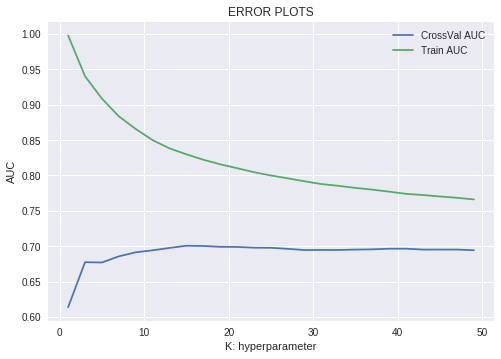

In [0]:
plt.plot(neighbour, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.plot(neighbour, Train_AUC_BOW, label='Train AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_k)

15


The optimal value of 'K' obtained is 15.




In [0]:
Classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
Classifier.fit(Train_BOW, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(Train_BOW)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(Test_BOW)[:,1])

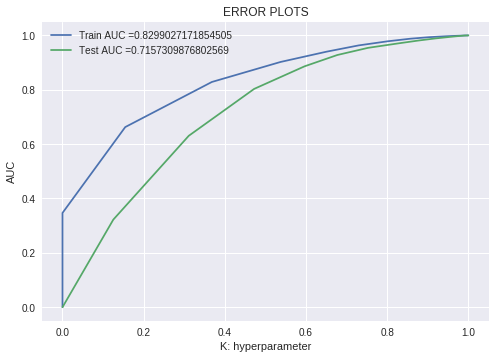

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


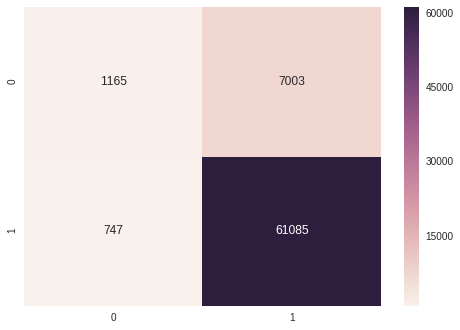

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(Train_BOW))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


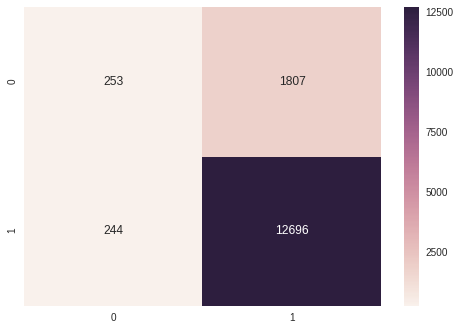

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(Test_BOW))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with K=15 on Test Dataset is  12949(86.32%).
2. The Area Under Curve value for Test Dataset is 0.71573(approx).
3. The brute-force method takes little less time for computation.

**1.2 K-D TREE METHOD**

**Note :**
We are using 20K data points (14K-TRAIN , 3K-CROSS_VALIDATE , 3K-TEST) for this model .

In [0]:
count= CountVectorizer(max_features=500,min_df=10)

In [0]:
count.fit(Train_x[:14000])
Train_BOW = count.transform(Train_x[:14000])
CrossVal_BOW = count.transform(Train_x[14000:17000])
Test_BOW= count.transform(Train_x[17000:20000]) 

In [0]:
Train_BOW_den=Train_BOW.toarray()
CrossVal_BOW_den=CrossVal_BOW.toarray()
Test_BOW_den=Test_BOW.toarray()

In [0]:
standardized_vec = StandardScaler(with_mean=False)
standardized_vec.fit(Train_BOW_den)

In [0]:
Train_BOW_std=standardized_vec.transform(Train_BOW_den)
CrossVal_BOW_std=standardized_vec.transform(CrossVal_BOW_den)
Test_BOW_std=standardized_vec.transform(Test_BOW_den)

**Hyperparameter( K ) tuning .**

In [0]:
Mylist=list(range(3,52))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in neighbour:
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
  neigh.fit(Train_BOW_std, Train_y[:14000])
  Train_y_pred =  neigh.predict_proba(Train_BOW_std)[:,1]
  Train_AUC_BOW.append(roc_auc_score(Train_y[:14000],Train_y_pred))
  CrossVal_y_pred =  neigh.predict_proba(CrossVal_BOW_std)[:,1]
  CrossVal_AUC_BOW.append(roc_auc_score(Train_y[14000:17000],CrossVal_y_pred))

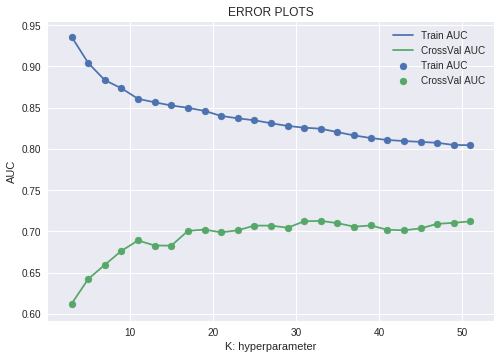

In [0]:
plt.plot(neighbour, Train_AUC_BOW, label='Train AUC')
plt.scatter(neighbour, Train_AUC_BOW, label='Train AUC')
plt.plot(neighbour, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(neighbour,CrossVal_AUC_BOW, label='CrossVal AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_k)

33


The optimal value of 'K' obtained is 33.

In [0]:
Classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
Classifier.fit(Train_BOW_std, Train_y[:14000])
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y[:14000], Classifier.predict_proba(Train_BOW_std)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Train_y[17000:20000], Classifier.predict_proba(Test_BOW_std)[:,1])

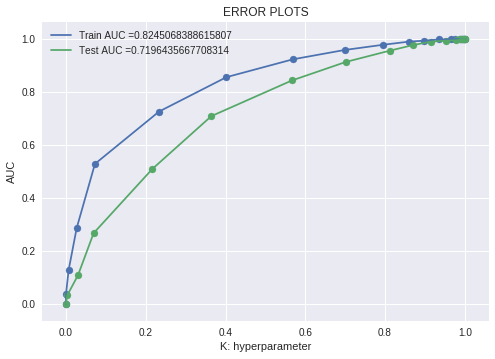

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.scatter(Train_FPR, Train_TPR)
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.scatter(Test_FPR, Test_TPR)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


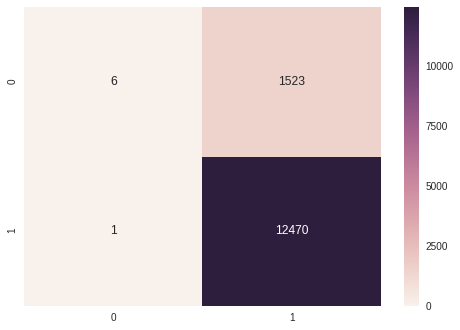

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y[:14000],Classifier.predict(Train_BOW_std))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


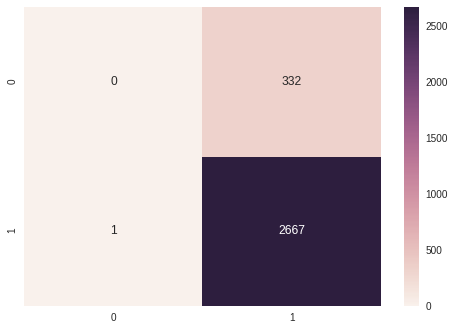

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Train_y[17000:20000],Classifier.predict(Test_BOW_std))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with K=33 on Test Dataset is  2667(88.9%) little more than brute-force method case .
2. The Area Under Curve value for Test Dataset is 0.719643(approx) a little more than brute-force method case.
3. The kd-tree method takes more time for computation.

**2. TF-IDF**

**2.1 BRUTE-FORCE METHOD**

In [0]:
tf_idf=TfidfVectorizer()

In [0]:
tf_idf.fit(Train_x)
Train_TFIDF = tf_idf.transform(Train_x)
CrossVal_TFIDF = tf_idf.transform(CrossVal_x)
Test_TFIDF= tf_idf.transform(Test_x) 

**Hyperparameter( K ) tuning .**

In [0]:
Mylist=list(range(3,52))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in neighbour:
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  neigh.fit(Train_TFIDF, Train_y)
  Train_y_pred =  neigh.predict_proba(Train_TFIDF)[:,1]
  Train_AUC_TFIDF.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  neigh.predict_proba(CrossVal_TFIDF)[:,1]
  CrossVal_AUC_TFIDF.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

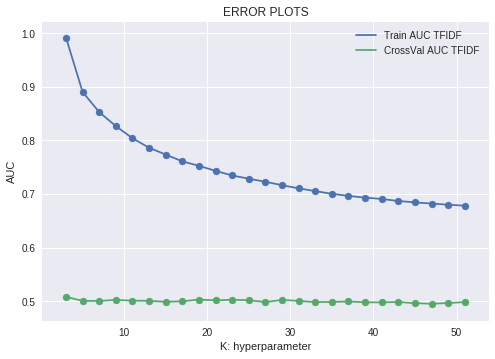

In [0]:
plt.plot(neighbour, Train_AUC_TFIDF, label='Train AUC TFIDF')
plt.scatter(neighbour, Train_AUC_TFIDF)
plt.plot(neighbour, CrossVal_AUC_TFIDF, label='CrossVal AUC TFIDF')
plt.scatter(neighbour, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_k)

3


The optimal value of 'K' obtained is 3.

In [0]:
Classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
Classifier.fit(Train_TFIDF, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(Train_TFIDF)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(Test_TFIDF)[:,1])

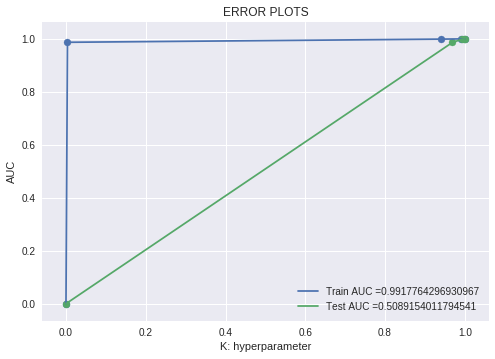

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.scatter(Train_FPR, Train_TPR)
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.scatter(Test_FPR, Test_TPR)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


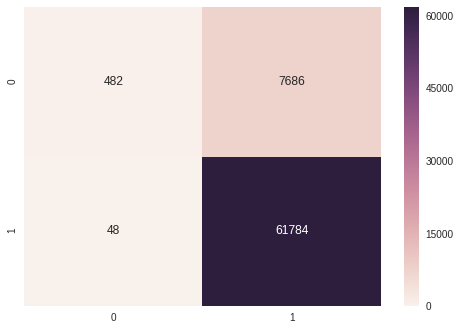

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(Train_TFIDF))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


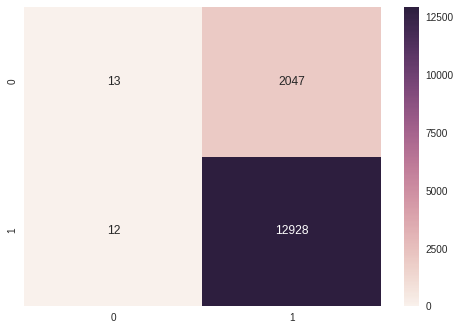

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(Test_TFIDF))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with K=3 on Test Dataset is  12941(86.27%).
2. The Area Under Curve value for Test Dataset is 0.50891(approx).
3. The brute-force method takes little less time for computation.
4. The Area Under Curve value is low with respect to other methods.

**2.2 K-D TREE METHOD**

**Note :**
We are using 20K data points (14K-TRAIN , 3K-CROSS_VALIDATE , 3K-TEST) for this model .

In [0]:
tf_idf=TfidfVectorizer(max_features=500,min_df=10)

In [0]:
tf_idf.fit(Train_x[:14000])
Train_TFIDF = tf_idf.transform(Train_x[:14000])
CrossVal_TFIDF = tf_idf.transform(Train_x[14000:17000])
Test_TFIDF= tf_idf.transform(Train_x[17000:20000]) 

In [0]:
Train_TFIDF_den=Train_TFIDF.toarray()
CrossVal_TFIDF_den=CrossVal_TFIDF.toarray()
Test_TFIDF_den=Test_TFIDF.toarray()

In [0]:
standardized_vec = StandardScaler(with_mean=False)
standardized_vec.fit(Train_TFIDF_den)

In [0]:
Train_TFIDF_std=standardized_vec.transform(Train_TFIDF_den)
CrossVal_TFIDF_std=standardized_vec.transform(CrossVal_TFIDF_den)
Test_TFIDF_std=standardized_vec.transform(Test_TFIDF_den)

**Hyperparameter( K ) tuning .**

In [0]:
Mylist=list(range(52))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in neighbour:
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
  neigh.fit(Train_TFIDF_std, Train_y[:14000])
  Train_y_pred =  neigh.predict_proba(Train_TFIDF_std)[:,1]
  Train_AUC_TFIDF.append(roc_auc_score(Train_y[:14000],Train_y_pred))
  CrossVal_y_pred =  neigh.predict_proba(CrossVal_TFIDF_std)[:,1]
  CrossVal_AUC_TFIDF.append(roc_auc_score(Train_y[14000:17000],CrossVal_y_pred))

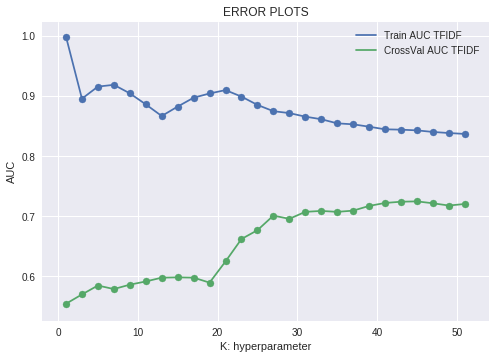

In [0]:
plt.plot(neighbour, Train_AUC_TFIDF, label='Train AUC TFIDF')
plt.scatter(neighbour, Train_AUC_TFIDF)
plt.plot(neighbour, CrossVal_AUC_TFIDF, label='CrossVal AUC TFIDF')
plt.scatter(neighbour, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_k)

45


The optimal value of 'K' obtained is 45.

In [0]:
Classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
Classifier.fit(Train_TFIDF_std, Train_y[:14000])
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y[:14000], Classifier.predict_proba(Train_TFIDF_std)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Train_y[17000:20000], Classifier.predict_proba(Test_TFIDF_std)[:,1])

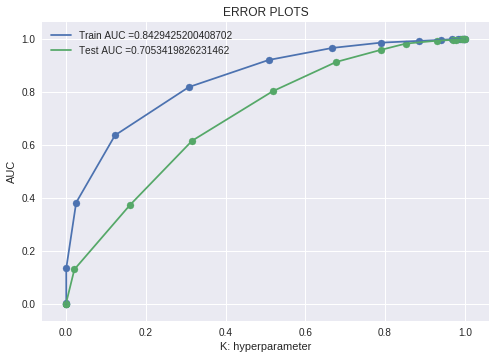

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.scatter(Train_FPR, Train_TPR)
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.scatter(Test_FPR, Test_TPR)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


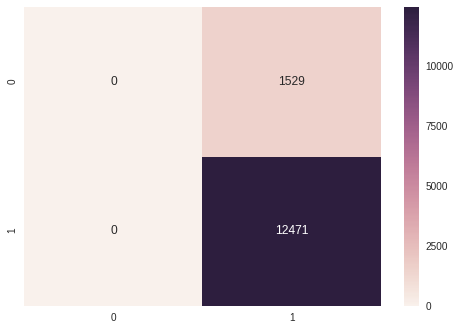

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y[:14000],Classifier.predict(Train_TFIDF_std))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


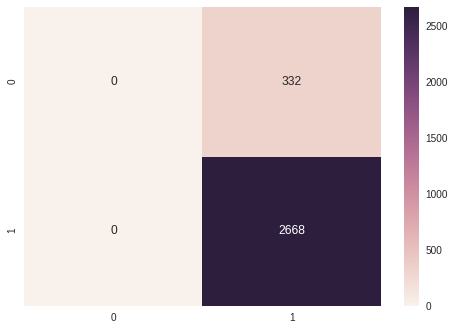

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Train_y[17000:20000],Classifier.predict(Test_TFIDF_std))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with K=45 on Test Dataset is  2668(88.9%) slightly more than brute-force method.
2. The Area Under Curve value for Test Dataset is 0.70534(approx) , more than brute-force method case.
3. The kd-tree method takes more time for computation.

**W0RD2VEC**

Converting the words of train data into vectors.

In [0]:
i=0
list_of_sentance_train=[]
for sentance in Train_x:
    list_of_sentance_train.append(sentance.split())

In [0]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

**3. AVERAGE WORD TO VECTOR.**

**Computing average word2vec for each review of Train Data .**

In [0]:
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train): 
  sent_vec = np.zeros(50) 
  cnt_words =0; 
  for word in sent:
    if word in w2v_words:
      vec = w2v_model.wv[word]
      sent_vec += vec
      cnt_words += 1
  if cnt_words != 0:
    sent_vec /= cnt_words
  sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)

**Computing average word2vec for each review of CrossValidate Data .**

In [0]:
i=0
list_of_sentance_cv=[]
for sentance in CrossVal_x:
    list_of_sentance_cv.append(sentance.split())

In [0]:
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv): 
  sent_vec = np.zeros(50) 
  cnt_words =0; 
  for word in sent:
    if word in w2v_words:
      vec = w2v_model.wv[word]
      sent_vec += vec
      cnt_words += 1
  if cnt_words != 0:
    sent_vec /= cnt_words
  sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)

**Computing average word2vec for each review of Test Data**

In [0]:
i=0
list_of_sentance_test=[]
for sentance in Test_x:
    list_of_sentance_test.append(sentance.split())

In [0]:
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test): 
  sent_vec = np.zeros(50) 
  cnt_words =0; 
  for word in sent:
    if word in w2v_words:
      vec = w2v_model.wv[word]
      sent_vec += vec
      cnt_words += 1
  if cnt_words != 0:
    sent_vec /= cnt_words
  sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)

**3.1 BRUTE-FORCE METHOD**

**Hyperparameter( K ) tuning .**

In [0]:
Mylist=list(range(3,52))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_W2VEC = []
CrossVal_AUC_W2VEC = []
for i in neighbour:
  print(i)
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  neigh.fit(sent_vectors_train, Train_y)
  Train_y_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
  Train_AUC_W2VEC.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
  CrossVal_AUC_W2VEC.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

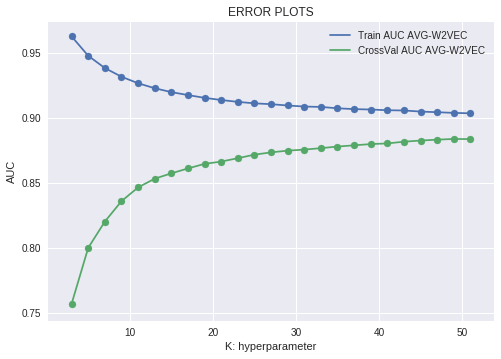

In [0]:
plt.plot(neighbour, Train_AUC_W2VEC, label='Train AUC AVG-W2VEC')
plt.scatter(neighbour, Train_AUC_W2VEC)
plt.plot(neighbour, CrossVal_AUC_W2VEC, label='CrossVal AUC AVG-W2VEC')
plt.scatter(neighbour, CrossVal_AUC_W2VEC)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_W2VEC.index(max(CrossVal_AUC_W2VEC))]
print(optimal_k)

49


The optimal value of 'K' obtained is 49.

In [0]:
Classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
Classifier.fit(sent_vectors_train, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(sent_vectors_train)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(sent_vectors_test)[:,1])

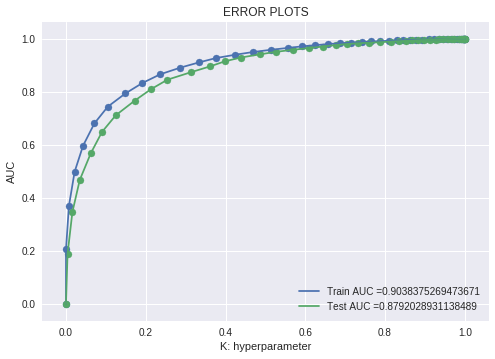

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.scatter(Train_FPR, Train_TPR)
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.scatter(Test_FPR, Test_TPR)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


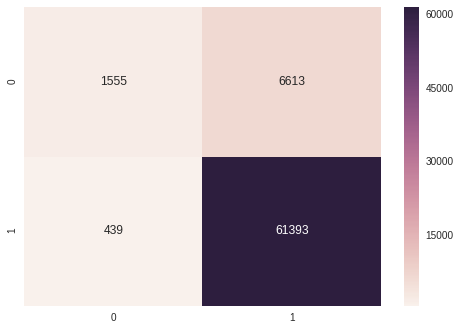

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(sent_vectors_train))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


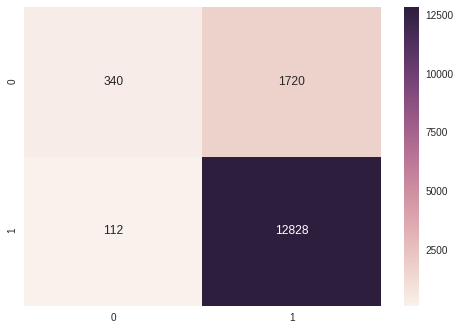

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(sent_vectors_test))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with K=49 on Test Dataset is  13168(87.78%).
2. The Area Under Curve value for Test Dataset is 0.87920(approx) .
3. The brute-force method takes little less time for computation.
4. The Area Under Curve value is very high with respect to other methods.

**3.2 K-D TREE METHOD**

**Hyperparameter( K ) tuning .**

In [0]:
Mylist=list(range(3,52))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_W2VEC = []
CrossVal_AUC_W2VEC = []
for i in neighbour:
  print(i)
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
  neigh.fit(sent_vectors_train, Train_y)
  Train_y_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
  Train_AUC_W2VEC.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
  CrossVal_AUC_W2VEC.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

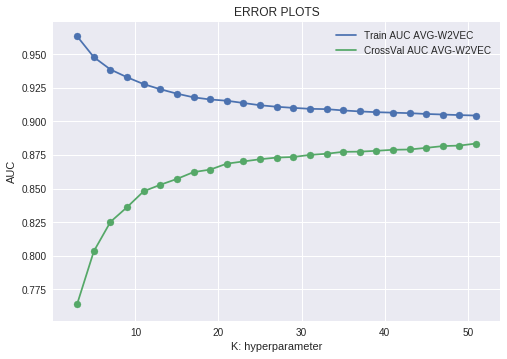

In [0]:
plt.plot(neighbour, Train_AUC_W2VEC, label='Train AUC AVG-W2VEC')
plt.scatter(neighbour, Train_AUC_W2VEC)
plt.plot(neighbour, CrossVal_AUC_W2VEC, label='CrossVal AUC AVG-W2VEC')
plt.scatter(neighbour, CrossVal_AUC_W2VEC)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_W2VEC.index(max(CrossVal_AUC_W2VEC))]
print(optimal_k)

51


The optimal value of 'K' obtained is 51.

In [0]:
Classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
Classifier.fit(sent_vectors_train, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(sent_vectors_train)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(sent_vectors_test)[:,1])

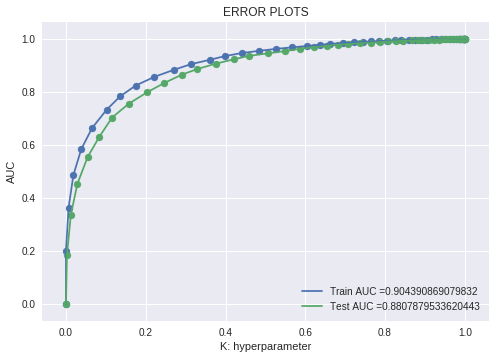

In [0]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.scatter(Train_FPR, Train_TPR)
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.scatter(Test_FPR, Test_TPR)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


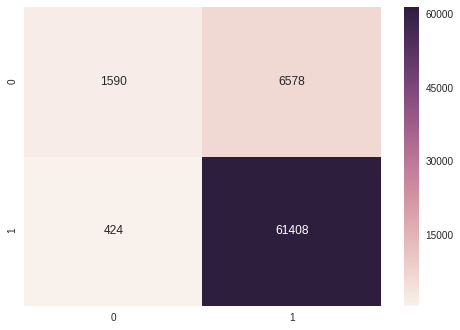

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(sent_vectors_train))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


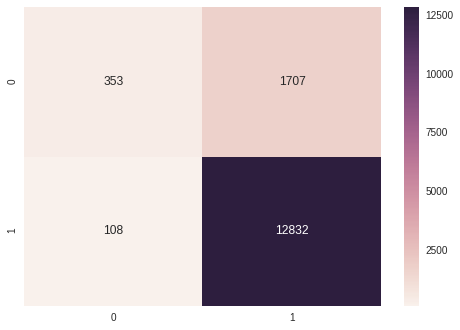

In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(sent_vectors_test))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with K=51 on Test Dataset is  13185( 87.9%) which is same as brute force method .
2. The Area Under Curve value for Test Dataset is 0.88078(approx) .
3. The kd-tree method takes more time for computation.
4. The Area Under Curve value is high with respect to other methods.

**4. TFIDF AVERAGE W2VEC.**

**Computing tfidf average word2vec for each review of Train dataset.**

In [0]:
tfidf_feat = tf_idf.get_feature_names()
AVG_TFIDF = []
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)  
    weight_sum =0; 
    for word in sent: 
        if((word in w2v_words)&(word in tfidf_feat)):
            vec = w2v_model.wv[word]
            TF_IDF = Train_TFIDF[row , tfidf_feat.index(word)]
            sent_vec += (vec * TF_IDF)
            weight_sum += TF_IDF
    if weight_sum != 0:
        sent_vec /= weight_sum
    AVG_TFIDF.append(sent_vec)
    row+=1;

100%|██████████| 70000/70000 [56:04<00:00, 20.81it/s]



**Computing tfidf average word2vec for each review of CrossValidate Data .**

In [0]:
i=0
list_of_sentance_cv=[]
for sentance in CrossVal_x:
    list_of_sentance_cv.append(sentance.split())

In [14]:
tfidf_feat = tf_idf.get_feature_names()
AVG_TFIDF_cv = []
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)  
    weight_sum =0; 
    for word in sent: 
        if((word in w2v_words)&(word in tfidf_feat)):
            vec = w2v_model.wv[word]
            TF_IDF = Train_TFIDF[row , tfidf_feat.index(word)]
            sent_vec += (vec * TF_IDF)
            weight_sum += TF_IDF
    if weight_sum != 0:
        sent_vec /= weight_sum
    AVG_TFIDF_cv.append(sent_vec)
    row+=1;

100%|██████████| 15000/15000 [11:47<00:00, 13.16it/s]


**Computing tfidf average word2vec for each review of Test Data .**

In [0]:
i=0
list_of_sentance_test=[]
for sentance in Test_x:
    list_of_sentance_test.append(sentance.split())

In [16]:
tfidf_feat = tf_idf.get_feature_names()
AVG_TFIDF_test = []
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)  
    weight_sum =0; 
    for word in sent: 
        if((word in w2v_words)&(word in tfidf_feat)):
            vec = w2v_model.wv[word]
            TF_IDF = Train_TFIDF[row , tfidf_feat.index(word)]
            sent_vec += (vec * TF_IDF)
            weight_sum += TF_IDF
    if weight_sum != 0:
        sent_vec /= weight_sum
    AVG_TFIDF_test.append(sent_vec)
    row+=1;

100%|██████████| 15000/15000 [11:52<00:00, 21.06it/s]


**4.1 BRUTE-FORCE METHOD**

**Hyperparameter( K ) tuning .**

In [0]:
Mylist=list(range(3,52))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_AVGTFIDF = []
CrossVal_AUC_AVGTFIDF = []
for i in neighbour:
  print(i)
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  neigh.fit(AVG_TFIDF, Train_y)
  Train_y_pred =  neigh.predict_proba(AVG_TFIDF)[:,1]
  Train_AUC_AVGTFIDF.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  neigh.predict_proba(AVG_TFIDF_cv)[:,1]
  CrossVal_AUC_AVGTFIDF.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

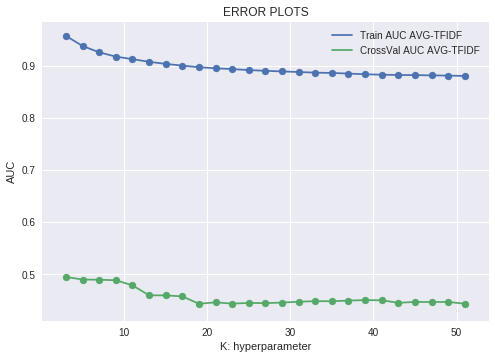

In [18]:
plt.plot(neighbour, Train_AUC_AVGTFIDF, label='Train AUC AVG-TFIDF')
plt.scatter(neighbour, Train_AUC_AVGTFIDF)
plt.plot(neighbour, CrossVal_AUC_AVGTFIDF, label='CrossVal AUC AVG-TFIDF')
plt.scatter(neighbour, CrossVal_AUC_AVGTFIDF)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [19]:
optimal_k=neighbour[CrossVal_AUC_AVGTFIDF.index(max(CrossVal_AUC_AVGTFIDF))]
print(optimal_k)

3


The optimal value of 'K' obtained is 3.

In [0]:
Classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
Classifier.fit(AVG_TFIDF, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(AVG_TFIDF)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(AVG_TFIDF_test)[:,1])

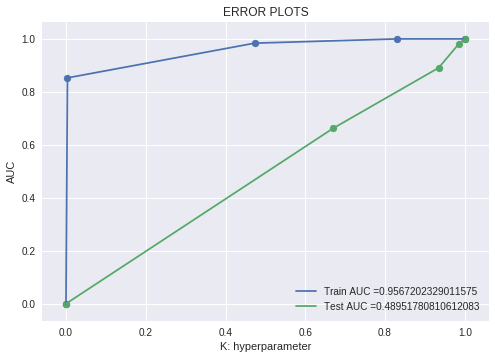

In [22]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.scatter(Train_FPR, Train_TPR)
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.scatter(Test_FPR, Test_TPR)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


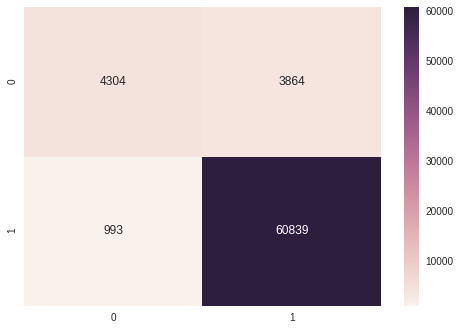

In [23]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(AVG_TFIDF))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


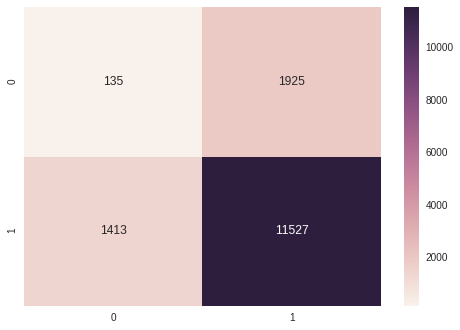

In [24]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(AVG_TFIDF_test))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with K=3 on Test Dataset is  11662(77.74%).
2. The Area Under Curve value for Test Dataset is 0.48951(approx) .
3. The brute-force method takes little less time for computation.
4. The Area Under Curve value is very low with respect to other methods.

**4.2 K-D TREE METHOD**

**Hyperparameter( K ) tuning .**

In [0]:
Mylist=list(range(3,52))
neighbour=list(filter(lambda x: x%2 != 0 , Mylist))
Train_AUC_AVGTFIDF = []
CrossVal_AUC_AVGTFIDF = []
for i in neighbour:
  print(i)
  neigh = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
  neigh.fit(AVG_TFIDF, Train_y)
  Train_y_pred =  neigh.predict_proba(AVG_TFIDF)[:,1]
  Train_AUC_AVGTFIDF.append(roc_auc_score(Train_y,Train_y_pred))
  CrossVal_y_pred =  neigh.predict_proba(AVG_TFIDF_cv)[:,1]
  CrossVal_AUC_AVGTFIDF.append(roc_auc_score(CrossVal_y,CrossVal_y_pred))

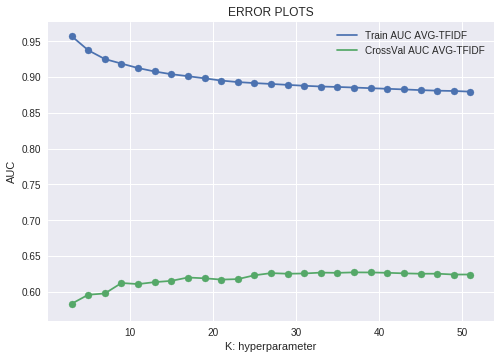

In [0]:
plt.plot(neighbour, Train_AUC_AVGTFIDF, label='Train AUC AVG-TFIDF')
plt.scatter(neighbour, Train_AUC_AVGTFIDF)
plt.plot(neighbour, CrossVal_AUC_AVGTFIDF, label='CrossVal AUC AVG-TFIDF')
plt.scatter(neighbour, CrossVal_AUC_AVGTFIDF)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_k=neighbour[CrossVal_AUC_AVGTFIDF.index(max(CrossVal_AUC_AVGTFIDF))]
print(optimal_k)

37


The optimal value of 'K' obtained is 37.

In [0]:
Classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
Classifier.fit(AVG_TFIDF, Train_y)
Train_FPR, Train_TPR, Thresholds = roc_curve(Train_y, Classifier.predict_proba(AVG_TFIDF)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(Test_y, Classifier.predict_proba(AVG_TFIDF_test)[:,1])

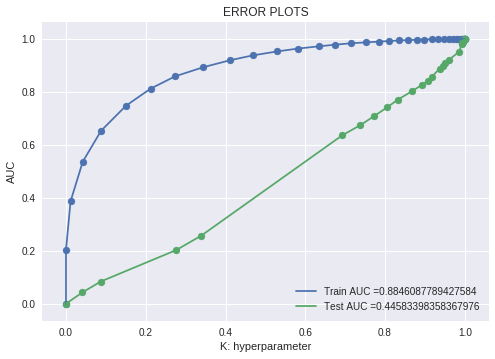

In [30]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.scatter(Train_FPR, Train_TPR)
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.scatter(Test_FPR, Test_TPR)
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix of Train Data


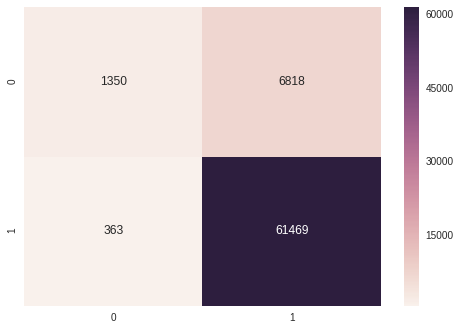

In [31]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(Train_y,Classifier.predict(AVG_TFIDF))
Train_cm = pd.DataFrame(Train_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Train_cm, annot=True,fmt="d")

Confusion Matrix of Test Data


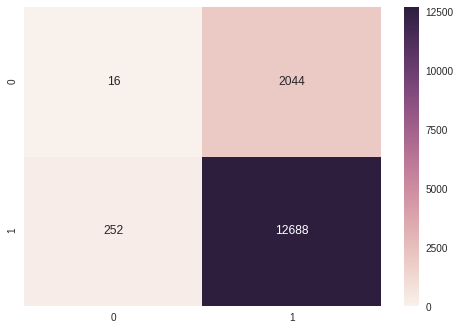

In [32]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(Test_y,Classifier.predict(AVG_TFIDF_test))
Test_cm = pd.DataFrame(Test_mat,index = [i for i in "01"],columns = [i for i in "01"])
sn.heatmap(Test_cm, annot=True,fmt="d")

**OBSERVATION.**
1. The correct prediction ( TP+TN ) of our model with K=37 on Test Dataset is  12704(84.69%) .
2. The Area Under Curve value for Test Dataset is 0.44583(approx) .
3. The kd-tree method takes more time for computation.
4. The Area Under Curve value is lowest with respect to other methods.

**FINAL TABLE**

In [35]:
x = PrettyTable()

x.field_names = ["VECTORIZER", "MODEL", "HYPER PARAMETER", "AREA UNDER CURVE"]

x.add_row(["BOW","BRUTE",15,0.71573])
x.add_row(["BOW","KD-TREE",33,0.71964])
x.add_row(["TFIDF","BRUTE",3,0.50891])
x.add_row(["TFIDF","KD-TREE",45,0.70534])
x.add_row(["AVG-W2VEC","BRUTE",49,0.87921])
x.add_row(["AVG-W2VEC","KD-TREE",51,0.88078])
x.add_row(["TFIDF-AVG W2VEC","BRUTE",3,0.48951])
x.add_row(["TFIDF-AVG W2VEC","KD-TREE",37,0.44583])
print(x)

+-----------------+---------+-----------------+------------------+
|    VECTORIZER   |  MODEL  | HYPER PARAMETER | AREA UNDER CURVE |
+-----------------+---------+-----------------+------------------+
|       BOW       |  BRUTE  |        15       |     0.71573      |
|       BOW       | KD-TREE |        33       |     0.71964      |
|      TFIDF      |  BRUTE  |        3        |     0.50891      |
|      TFIDF      | KD-TREE |        45       |     0.70534      |
|    AVG-W2VEC    |  BRUTE  |        49       |     0.87921      |
|    AVG-W2VEC    | KD-TREE |        51       |     0.88078      |
| TFIDF-AVG W2VEC |  BRUTE  |        3        |     0.48951      |
| TFIDF-AVG W2VEC | KD-TREE |        37       |     0.44583      |
+-----------------+---------+-----------------+------------------+


**POINTS**

*   AVG-W2VEC KD-TREE model is the best model with AUC value 0.88
*   TFIDF-AVG W2VEC KD-TREE model has the lowest value of AUC(  0.44583 ) among all the models.



**............................................................................................................................................END...............................................................................................**